# Data

This notebook extracts time-series data from the following parcellation atlases and prepare them for further analysis:

In [1]:
%reload_ext autoreload
%autoreload complete

from pathlib import Path
from tqdm.auto import tqdm

import pandas as pd
import xarray as xr
import numpy as np

from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from src.acnets.pipeline.parcellation import Parcellation


In [2]:
BIDS_DIR = 'data/julia2018'
PARCELLATION_CACHE_DIR = 'data/julia2018/derivatives/resting_timeseries/'

In [3]:
# data

from src.acnets.pipeline.multiscale_classifier import ExtractH3Features

p = Parcellation(atlas_name='dosenbach2010')
e = ExtractH3Features.get_pipeline()

dataset = p.fit_transform(None)
fetures = e.fit_transform(dataset)

data = pd.DataFrame(
    e.fit_transform(dataset),
    columns=e.get_feature_names_out(),
    index = dataset['subject']
)

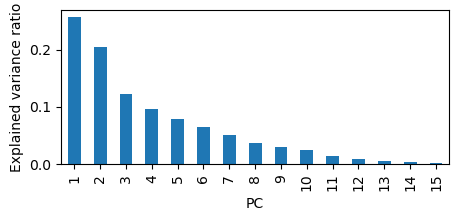

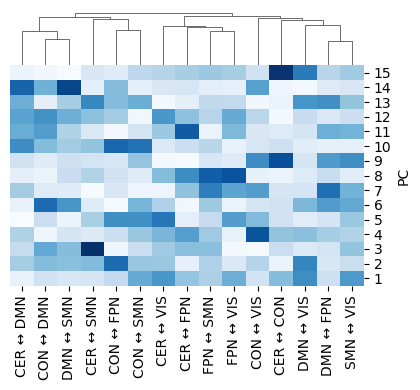

In [5]:
# H1-regions PCA

from sklearn.decomposition import FastICA

X = data.values
y = data.index.to_series().apply(lambda x: x[:4]).values

# pca = FastICA(n_components=min(*X.shape))
pca = PCA(n_components=min(*X.shape))

X_pca = pca.fit_transform(X)

explained_variance = pd.DataFrame(pca.explained_variance_ratio_,
                                  index=range(1, pca.n_components_+1),
                                  columns=['explain_variance_ratio'])
explained_variance.plot.bar(figsize=(5, 2), legend=False)
plt.xlabel('PC')
plt.ylabel('Explained variance ratio')
plt.show()

# H2 features
# loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings = pca.components_
loadings = pd.DataFrame(loadings, index=data.columns, columns=range(1, pca.n_components+1))

loadings = loadings.abs()
g = sns.clustermap(loadings.T, cmap='Blues',
                   row_cluster=False,
                   figsize=(5,4))
g.ax_heatmap.invert_yaxis()
g.cax.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
g.ax_heatmap.set_ylabel('PC')
plt.show()

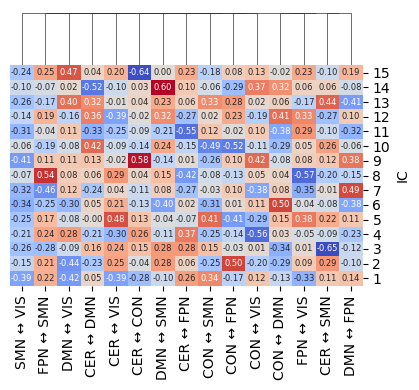

In [6]:
# ICA

# H1-regions PCA

from sklearn.decomposition import FastICA

X = data.values
y = data.index.to_series().apply(lambda x: x[:4]).values

ica = FastICA(n_components=min(*X.shape))

X_ica = ica.fit_transform(X)

# H2 features
# loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings = pca.components_
loadings = pd.DataFrame(loadings, index=data.columns, columns=range(1, ica.n_components+1))

g = sns.clustermap(loadings.T, cmap='coolwarm',
                   row_cluster=False,
                   annot=True,
                   annot_kws={'fontsize': 6},
                   
                   fmt='.2f',
                   figsize=(5,4))
g.ax_heatmap.invert_yaxis()
g.cax.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
g.ax_heatmap.set_ylabel('IC')
plt.show()